## ME5413: Autonomous Mobile Robot  

### Homework 1: Perception  
Due date: 22 February 2024 (Thurs) - 2359 


#### Import requirements

In [49]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd 

### Task 1.1 Single-Object Tracking 


## 1. Using Template Matching


### 1.1 Apply Template matching for different mapping methods

---

**Template Matching with Multiple Methods:**

The script performs template matching on a sequence of images using different OpenCV matching techniques. These include:

- `TM_CCOEFF`
- `TM_CCOEFF_NORMED`
- `TM_CCORR_NORMED`
- `TM_SQDIFF`
- `TM_SQDIFF_NORMED`

For each method, it follows these steps:

1. **Initialization:** Reads the initial bounding box and extracts the template from the first image.
2. **Matching:** Applies template matching across the image sequence.
3. **Result Saving:** Stores the coordinates of matched regions.
4. **Visualization:** Displays matches alongside ground truth bounding boxes.
5. **Cleanup:** Closes all OpenCV windows after processing.

---


#### 1.1.1 Function to perform template matching and Visualization

In [50]:
# Reads the initial position and size of the tracking window from a file.
def read_first_track(first_track_path):
    with open(first_track_path, 'r') as file:
        # Expecting a line with 'x,y,width,height' format.
        x, y, w, h = map(int, file.readline().strip().split(','))
    return x, y, w, h

# Reads ground truth bounding boxes from a file for each frame.
def read_ground_truth(ground_truth_path):
    with open(ground_truth_path, 'r') as file:
        # Each line corresponds to a frame's bounding box in 'x,y,width,height' format.
        return [tuple(map(int, line.strip().split(','))) for line in file]

# This function performs template matching on a sequence of images and saves the results.
def template_match_and_save_results(sequence_path, first_track_path):
    # Read the initial tracking box coordinates and dimensions.
    x, y, w, h = read_first_track(first_track_path)
    # Construct the path to the first image in the sequence.
    first_image_path = os.path.join(sequence_path, "001.jpg")
    # Read and extract the template region from the first image.
    template = cv2.imread(first_image_path)[y:y+h, x:x+w]

    # Define a dictionary of OpenCV's template matching methods for iteration.
    method_names = {
        cv2.TM_CCOEFF: 'TM_CCOEFF',
        cv2.TM_CCOEFF_NORMED: 'TM_CCOEFF_NORMED',
        cv2.TM_CCORR_NORMED: 'TM_CCORR_NORMED',
        cv2.TM_SQDIFF: 'TM_SQDIFF',
        cv2.TM_SQDIFF_NORMED: 'TM_SQDIFF_NORMED'
    }

    # Iterate over each method to perform template matching.
    for method, method_name in method_names.items():
        # Create a directory to save the match results for the current method.
        match_folder_path = os.path.join(sequence_path, '..', f"match_{method_name}")
        os.makedirs(match_folder_path, exist_ok=True)
        
        # Perform template matching for each image in the sequence.
        for i in range(1, 101):  # Loop through image indices assuming 100 images.
            image_path = os.path.join(sequence_path, f"{str(i).zfill(3)}.jpg")
            img = cv2.imread(image_path)
            # Apply template matching using the current method.
            res = cv2.matchTemplate(img, template, method)
            # Find the location of the best match.
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            # Determine the top-left corner of the matched area.
            top_left = min_loc if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else max_loc

            # Save the coordinates of the matched region to a results file.
            with open(os.path.join(match_folder_path, f"results_{method_name}.txt"), 'a') as file:
                file.write(f"{top_left[0]},{top_left[1]},{w},{h}\n")


# Displays the template matching results and the ground truth bounding boxes on the images.
def display_matched_images_with_groundtruth(sequence_path, method_names, w, h):
    # Get the path to the ground truth data and read it.
    ground_truth_path = os.path.join(sequence_path, '..', 'groundtruth.txt')
    ground_truth_data = read_ground_truth(ground_truth_path)

    # Iterate over the specified template matching methods.
    for method in method_names:
        # Construct the path to the folder containing the results of the current method.
        match_folder_path = os.path.join(sequence_path, '..', f"match_{method}")
        results_path = os.path.join(match_folder_path, f"results_{method}.txt")
        # Read the matched results from the results file.
        with open(results_path, 'r') as file:
            matched_results = [tuple(map(int, line.strip().split(','))) for line in file]
        
        # Create a resizable window to display the results.
        cv2.namedWindow(method, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(method, 600, 400)

        # Loop through each ground truth bounding box and display it with the matched box.
        for i, (gt_x, gt_y, gt_w, gt_h) in enumerate(ground_truth_data):
            # Construct the path to the current image and read it.
            image_path = os.path.join(sequence_path, f"{str(i+1).zfill(3)}.jpg")
            frame = cv2.imread(image_path)

            # If the frame is read successfully, draw the bounding boxes.
            if frame is not None:
                # Draw the ground truth box in blue.
                cv2.rectangle(frame, (gt_x, gt_y), (gt_x + gt_w, gt_y + gt_h), (255, 0, 0), 2)
                
                # Draw the matched box in yellow.
                mt_x, mt_y, _, _ = matched_results[i]
                cv2.rectangle(frame, (mt_x, mt_y), (mt_x + w, mt_y + h), (0, 255, 255), 2)

                # Display the frame in the window and wait for a key press.
                cv2.imshow(method, frame)
                if cv2.waitKey(30) & 0xFF == ord('q'):
                    break

        # After displaying all frames, close the window for the current method.
        cv2.destroyWindow(method)

# Base directory for the sequence of images.
sequence_dir_base = 'data/Task 1'
# Filename for the initial tracking box coordinates.
first_track_file = 'firsttrack.txt'

# Loop through each sequence from 1 to 5.
for seq_num in range(1, 6):
    # Construct the path to the image sequence and the initial tracking box file.
    sequence_path = os.path.join(sequence_dir_base, f'seq_{seq_num}', 'img')
    first_track_path = os.path.join(sequence_dir_base, f'seq_{seq_num}', first_track_file)
    
    # Read the initial tracking box dimensions.
    _, _, w, h = read_first_track(first_track_path)
    
    # Perform template matching for the current sequence and save the results.
    template_match_and_save_results(sequence_path, first_track_path)
    
    # Display the results alongside the ground truth bounding boxes.
    display_matched_images_with_groundtruth(
        sequence_path,
        ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED'],
        w, h
    )

# Clean up and close any OpenCV windows after the processing is done.
cv2.destroyAllWindows()

## 2. Using Kalman Filter with ground truth.txt


### Kalman Filter Implementation and Visualization 

Certainly! Here's a brief markdown description that can be copied directly:

---

#### Kalman Filter Object Tracking

The provided code implements object tracking using a Kalman filter across a sequence of images:

- Initializes the Kalman filter with the object's initial position and size.
- Reads ground truth bounding boxes for comparison.
- Predicts the object's position in each new frame using the Kalman filter.
- Corrects the prediction with the ground truth.
- Visualizes the results by drawing both predicted and ground truth bounding boxes on each image.
- Processes multiple sequences from a specified directory.

The code applies this tracking to a dataset located in `data/Task 1`, iterating through each sequence from `seq_1` to `seq_5`.

---

In [ ]:
# Initialize a Kalman Filter to track an object based on its initial bounding box.
def initialize_kalman(x, y, w, h):
    kf = cv2.KalmanFilter(4, 2)  # Create Kalman Filter with 4 dynamic params (x, y, dx, dy) and 2 measured params (x, y).
    # Define how measurements and state updates are mapped.
    kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    # Define state transition (including assumed constant velocity model).
    kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    # Process noise covariance (small values mean less noise).
    kf.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03
    # Measurement noise covariance (increase values to give less weight to measurements).
    kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.1
    # Initial state estimate (object's center position and initial velocity assumed as 0).
    kf.statePre = np.array([x + w / 2, y + h / 2, 0, 0], dtype=np.float32)
    # Initial error covariance matrix.
    kf.errorCovPre = np.eye(4, dtype=np.float32)
    return kf

# Read the initial bounding box of the object from a file.
def read_initial_state(file_path):
    with open(file_path, 'r') as f:
        # Extract the bounding box coordinates and size.
        x, y, w, h = map(int, f.readline().strip().split(','))
    return x, y, w, h

# Track an object across a sequence of images and visualize the tracking with ground truth.
def track_and_visualize(sequence_path, initial_state_path, ground_truth_path):
    # Initialize the Kalman filter with the initial state.
    x, y, w, h = read_initial_state(initial_state_path)
    kf = initialize_kalman(x, y, w, h)
    
    # Read ground truth data for comparison.
    with open(ground_truth_path, 'r') as f:
        ground_truth_data = [list(map(int, line.strip().split(','))) for line in f]
    
    # Iterate over each frame in the sequence.
    for i, (x, y, w, h) in enumerate(ground_truth_data):
        image_path = os.path.join(sequence_path, f"{str(i+1).zfill(3)}.jpg")
        frame = cv2.imread(image_path)
        
        if frame is not None:
            # Predict the object's location.
            prediction = kf.predict()
            # Correct the prediction using the current ground truth.
            kf.correct(np.array([x + w / 2, y + h / 2], np.float32))
            
            # Draw the predicted and actual bounding boxes.
            cv2.rectangle(frame, (int(prediction[0] - w / 2), int(prediction[1] - h / 2)), 
                          (int(prediction[0] + w / 2), int(prediction[1] + h / 2)), (255, 0, 0), 2)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Display the frame with annotations.
            cv2.imshow(f"Sequence {sequence_path.split('/')[-2]}", frame)
            cv2.waitKey(30)
    # Close all OpenCV windows after processing.
    cv2.destroyAllWindows()

# Main execution: process each sequence of images.
base_dir = 'data/Task 1'
for seq_num in range(1, 6):
    sequence_folder = f'seq_{seq_num}'
    sequence_path = os.path.join(base_dir, sequence_folder, 'img')
    initial_state_path = os.path.join(base_dir, sequence_folder, 'firsttrack.txt')
    ground_truth_path = os.path.join(base_dir, sequence_folder, 'groundtruth.txt')
    
    print(f"Processing {sequence_folder}...")
    track_and_visualize(sequence_path, initial_state_path, ground_truth_path)


Processing seq_1...
Processing seq_2...
Processing seq_3...
Processing seq_4...
Processing seq_5...


## Evaluate the performance of the Single object tracking algorithm.

### Evaluating performance of the template matching 

---

This script evaluates the performance of object tracking algorithms by calculating the Intersection over Union (IoU) and precision metrics for each tracking method across a series of image sequences. It processes multiple sequences, each containing ground truth bounding boxes and predicted bounding boxes generated by various template matching methods.

##### Key Components:

- **Read Bounding Boxes:** Extracts bounding box coordinates from text files, representing the ground truth and predicted positions of the object in each frame.

- **Calculate IoU:** Computes the Intersection over Union metric for each pair of ground truth and predicted bounding boxes, providing a measure of overlap accuracy.

- **Calculate Precision:** Determines the precision of the prediction by calculating the Euclidean distance between the centers of the ground truth and predicted bounding boxes.

- **Performance Evaluation:** Iterates over each sequence and tracking method to accumulate IoU and precision values, calculating average scores for a comprehensive evaluation.

- **Visualization:** Generates bar charts to visually compare the average precision and IoU scores for each tracking method across all sequences, aiding in the identification of the most accurate tracking approach.

The script operates on a predetermined dataset located within "data/Task 1", assessing the performance of five distinct template matching methods: `TM_CCOEFF`, `TM_CCOEFF_NORMED`, `TM_CCORR_NORMED`, `TM_SQDIFF`, and `TM_SQDIFF_NORMED`.

---

Sequence 1, Method TM_CCOEFF: Average Precision = 138.95, Average IoU = 0.45
Sequence 1, Method TM_CCOEFF_NORMED: Average Precision = 115.41, Average IoU = 0.50
Sequence 1, Method TM_CCORR_NORMED: Average Precision = 193.42, Average IoU = 0.47
Sequence 1, Method TM_SQDIFF: Average Precision = 72.01, Average IoU = 0.54
Sequence 1, Method TM_SQDIFF_NORMED: Average Precision = 161.14, Average IoU = 0.47
Sequence 2, Method TM_CCOEFF: Average Precision = 79.42, Average IoU = 0.39
Sequence 2, Method TM_CCOEFF_NORMED: Average Precision = 121.84, Average IoU = 0.28
Sequence 2, Method TM_CCORR_NORMED: Average Precision = 135.46, Average IoU = 0.23
Sequence 2, Method TM_SQDIFF: Average Precision = 109.93, Average IoU = 0.32
Sequence 2, Method TM_SQDIFF_NORMED: Average Precision = 130.58, Average IoU = 0.25
Sequence 3, Method TM_CCOEFF: Average Precision = 255.46, Average IoU = 0.38
Sequence 3, Method TM_CCOEFF_NORMED: Average Precision = 239.84, Average IoU = 0.34
Sequence 3, Method TM_CCORR_NOR

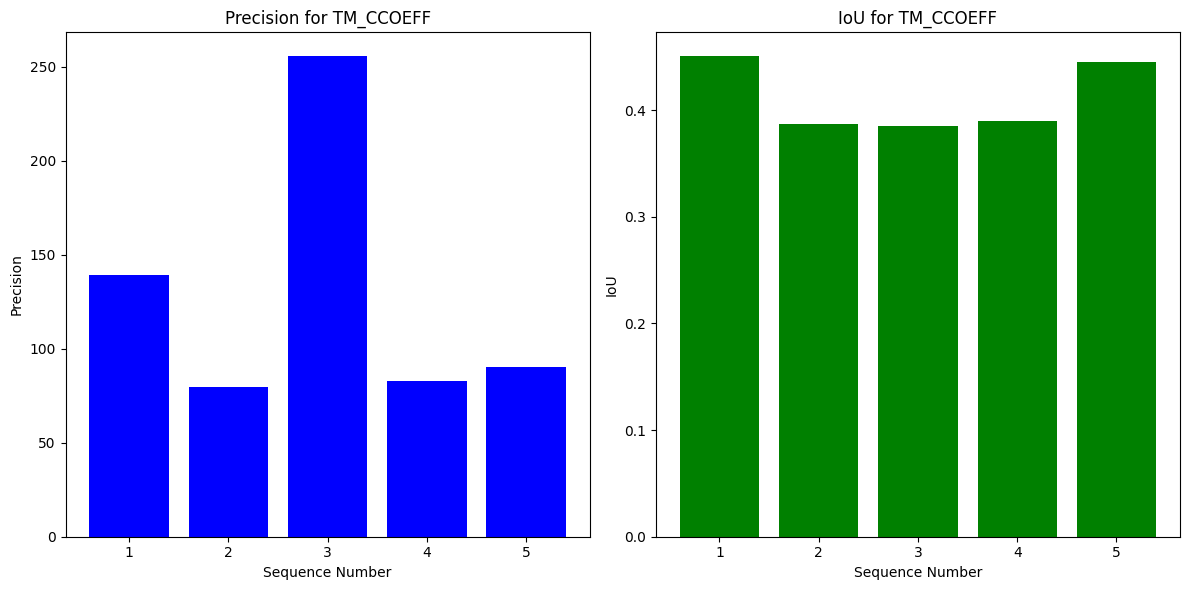

Method TM_CCOEFF_NORMED: Overall Average Precision = 142.41, Overall Average IoU = 0.36


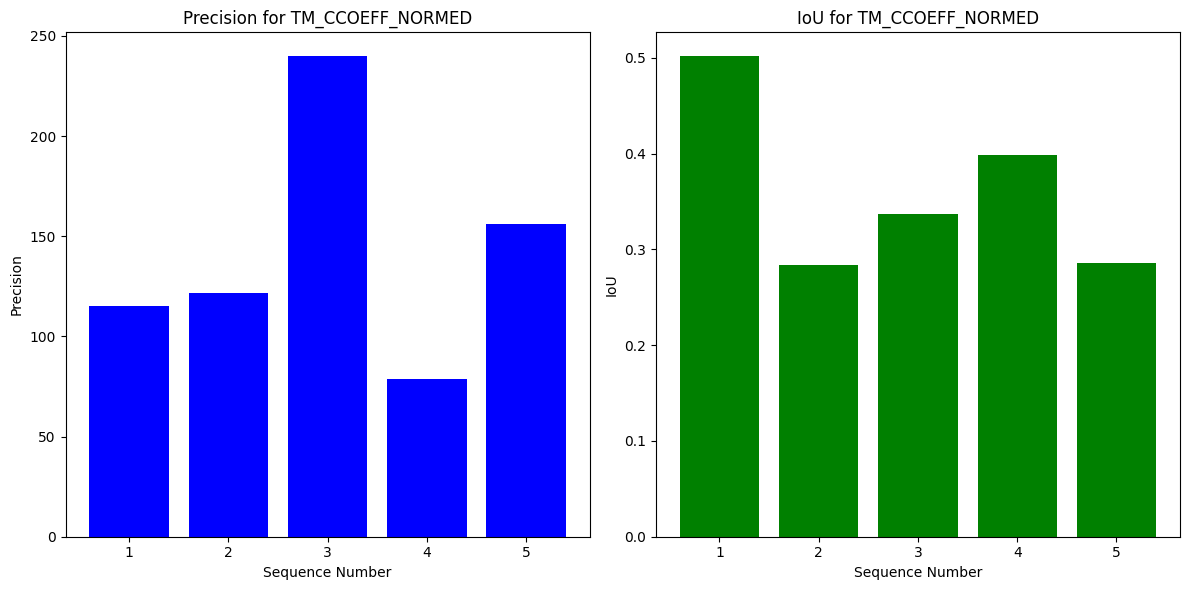

Method TM_CCORR_NORMED: Overall Average Precision = 163.45, Overall Average IoU = 0.29


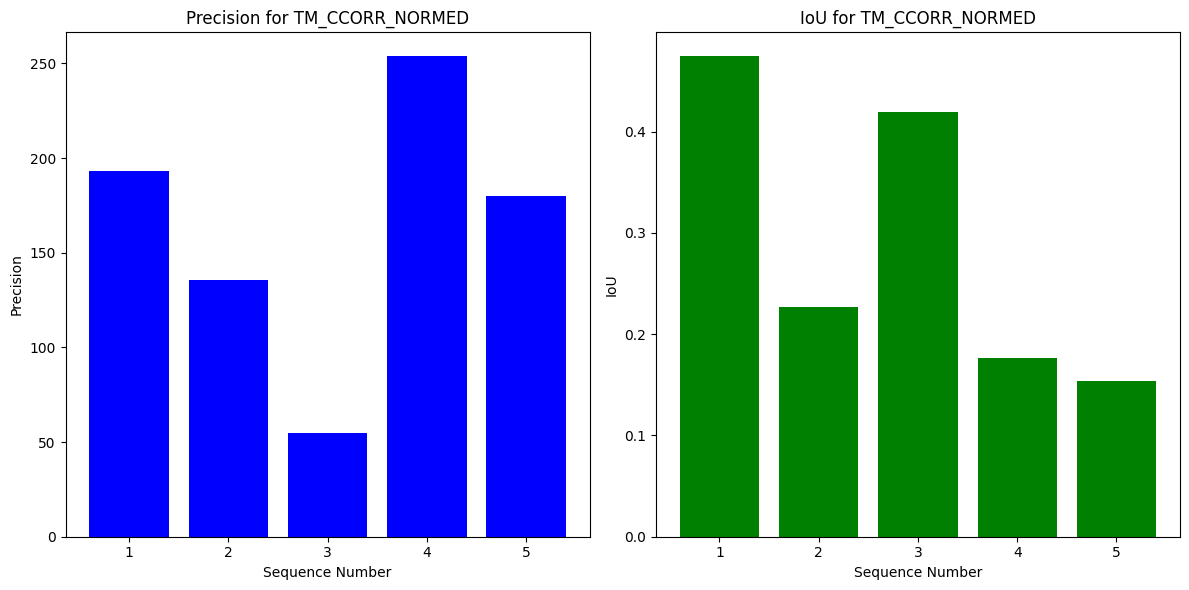

Method TM_SQDIFF: Overall Average Precision = 185.33, Overall Average IoU = 0.30


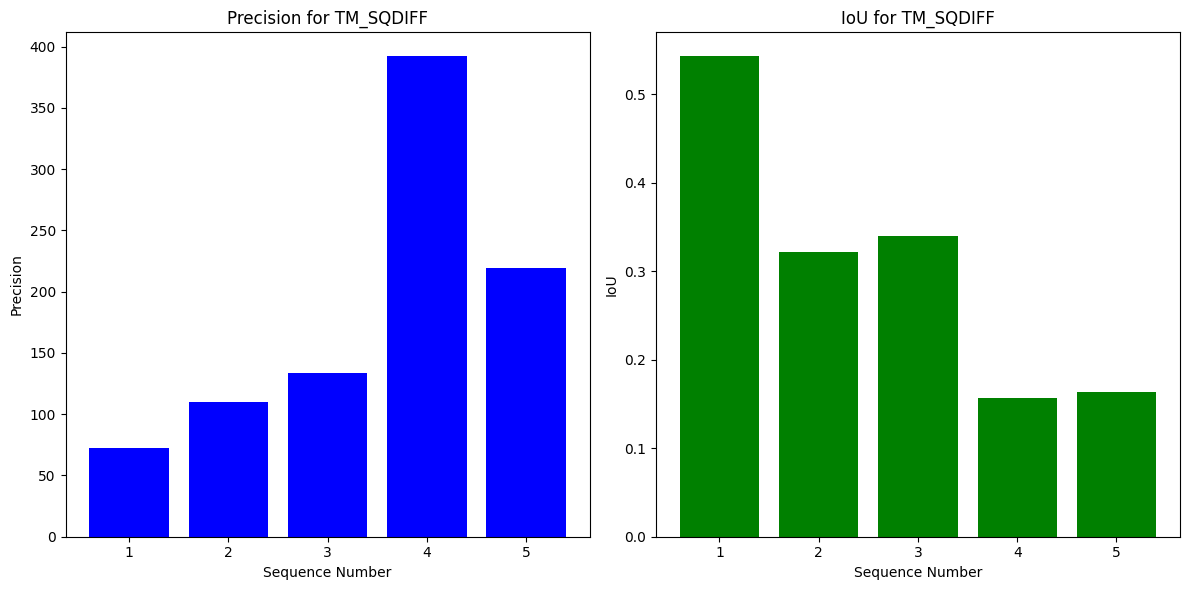

Method TM_SQDIFF_NORMED: Overall Average Precision = 166.96, Overall Average IoU = 0.31


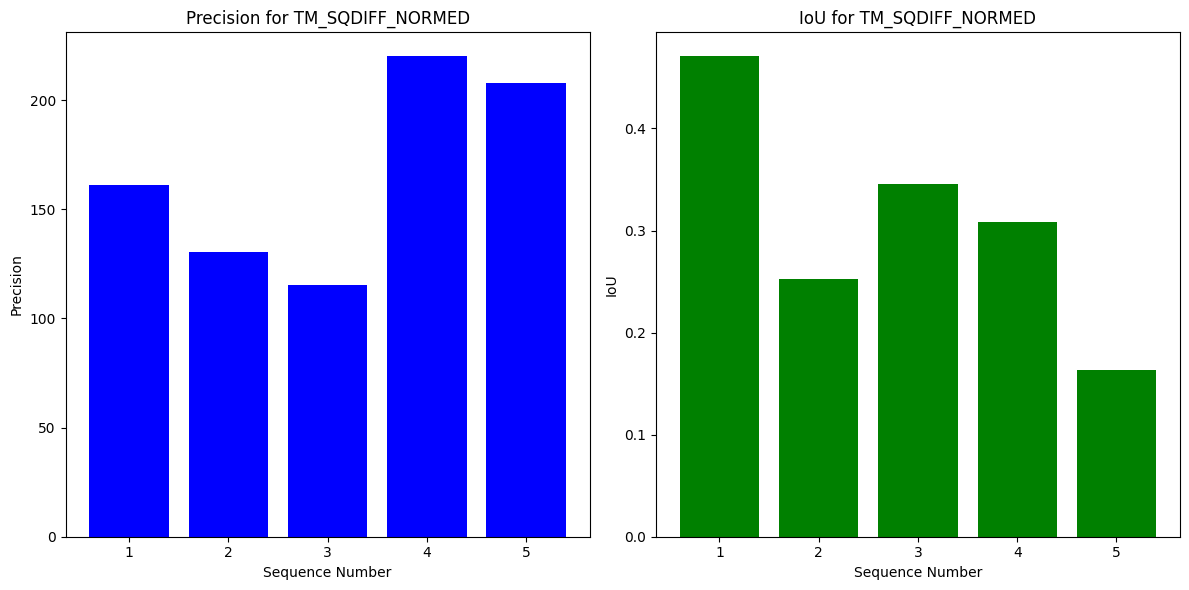

In [ ]:
# Function to read bounding box coordinates from a file.
def read_bounding_boxes(file_path):
    # Open the file and read each line, converting each value to an integer.
    with open(file_path, 'r') as file:
        return [tuple(map(int, line.strip().split(','))) for line in file]

# Function to calculate the Intersection over Union (IoU) between two bounding boxes.
def calculate_iou(box1, box2):
    # Calculate the (x, y) coordinates of the intersection rectangle.
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[0]+box1[2], box2[0]+box2[2])
    y_bottom = min(box1[1]+box1[3], box2[1]+box2[3])

    # Return 0 if there's no overlap.
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate areas of intersection and union, then compute IoU.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = box1[2] * box1[3]
    bb2_area = box2[2] * box2[3]
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

# Function to calculate the precision based on the distance between center points of two boxes.
def calculate_precision(gt_box, pred_box):
    # Calculate center points of both boxes.
    gt_center = np.array([gt_box[0] + gt_box[2] / 2, gt_box[1] + gt_box[3] / 2])
    pred_center = np.array([pred_box[0] + pred_box[2] / 2, pred_box[1] + pred_box[3] / 2])
    # Return Euclidean distance between centers as the precision.
    return np.linalg.norm(gt_center - pred_center)

# Main execution block.
base_dir = 'data/Task 1'
# Define the template matching methods to evaluate.
method_names = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']

# Initialize dictionaries to store precision and IoU values for each method.
overall_precision = {method: [] for method in method_names}
overall_iou = {method: [] for method in method_names}

# Process each sequence in the dataset.
for seq_num in range(1, 6):
    sequence_folder = f'seq_{seq_num}'
    # Construct paths to the ground truth and method result files.
    ground_truth_path = os.path.join(base_dir, sequence_folder, 'groundtruth.txt')
    ground_truth_boxes = read_bounding_boxes(ground_truth_path)

    for method in method_names:
        result_path = os.path.join(base_dir, sequence_folder, f'match_{method}', f"results_{method}.txt")
        # Skip if results file doesn't exist.
        if not os.path.exists(result_path):
            print(f"File not found: {result_path}")
            continue
        method_boxes = read_bounding_boxes(result_path)

        # Accumulate precision and IoU for the current method.
        precision_accumulator = []
        iou_accumulator = []
        for gt_box, pred_box in zip(ground_truth_boxes, method_boxes):
            precision = calculate_precision(gt_box, pred_box)
            iou = calculate_iou(gt_box, pred_box)
            precision_accumulator.append(precision)
            iou_accumulator.append(iou)

        # Calculate average precision and IoU for the current method and sequence.
        avg_precision = np.mean(precision_accumulator)
        avg_iou = np.mean(iou_accumulator)
        overall_precision[method].append(avg_precision)
        overall_iou[method].append(avg_iou)

        print(f"Sequence {seq_num}, Method {method}: Average Precision = {avg_precision:.2f}, Average IoU = {avg_iou:.2f}")

# Calculate and display overall average precision and IoU for each method.
for method in method_names:
    avg_precision = np.mean(overall_precision[method])
    avg_iou = np.mean(overall_iou[method])
    print(f"Method {method}: Overall Average Precision = {avg_precision:.2f}, Overall Average IoU = {avg_iou:.2f}")
    
    # Visualization of the results.
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, 6), overall_precision[method], color='blue')
    plt.title(f"Precision for {method}")
    plt.xlabel("Sequence Number")
    plt.ylabel("Precision")
    
    plt.subplot(1, 2, 2)
    plt.bar(range(1, 6), overall_iou[method], color='green')
    plt.title(f"IoU for {method}")
    plt.xlabel("Sequence Number")
    plt.ylabel("IoU")
    
    plt.tight_layout()
    plt.show()


#### Saving the results in CSV

In [ ]:
# Directory and method setup
base_dir = 'data/Task 1'
method_names = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']

# Prepare to save the results in CSV
results_filename = os.path.join(base_dir, 'tracking_evaluation_results.csv')

# Write headers to the CSV file
with open(results_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Sequence', 'Method', 'Average Precision', 'Average IoU'])

# Process and save the results
for seq_num in range(1, 6):
    sequence_folder = f'seq_{seq_num}'
    ground_truth_path = os.path.join(base_dir, sequence_folder, 'groundtruth.txt')
    ground_truth_boxes = read_bounding_boxes(ground_truth_path)

    for method in method_names:
        result_path = os.path.join(base_dir, sequence_folder, f'match_{method}', f"results_{method}.txt")
        
        if not os.path.exists(result_path):
            print(f"File not found: {result_path}")
            continue
        
        method_boxes = read_bounding_boxes(result_path)
        precision_accumulator = []
        iou_accumulator = []

        for gt_box, pred_box in zip(ground_truth_boxes, method_boxes):
            precision = calculate_precision(gt_box, pred_box)
            iou = calculate_iou(gt_box, pred_box)
            precision_accumulator.append(precision)
            iou_accumulator.append(iou)

        avg_precision = np.mean(precision_accumulator)
        avg_iou = np.mean(iou_accumulator)

        # Print to console
        print(f"Sequence {seq_num}, Method {method}: Average Precision = {avg_precision:.2f}, Average IoU = {avg_iou:.2f}")

        # Save the results to the CSV file
        with open(results_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([sequence_folder, method, avg_precision, avg_iou])

# No plotting in this snippet; we focus on saving the results.


Sequence 1, Method TM_CCOEFF: Average Precision = 138.95, Average IoU = 0.45
Sequence 1, Method TM_CCOEFF_NORMED: Average Precision = 115.41, Average IoU = 0.50
Sequence 1, Method TM_CCORR_NORMED: Average Precision = 193.42, Average IoU = 0.47
Sequence 1, Method TM_SQDIFF: Average Precision = 72.01, Average IoU = 0.54
Sequence 1, Method TM_SQDIFF_NORMED: Average Precision = 161.14, Average IoU = 0.47
Sequence 2, Method TM_CCOEFF: Average Precision = 79.42, Average IoU = 0.39
Sequence 2, Method TM_CCOEFF_NORMED: Average Precision = 121.84, Average IoU = 0.28
Sequence 2, Method TM_CCORR_NORMED: Average Precision = 135.46, Average IoU = 0.23
Sequence 2, Method TM_SQDIFF: Average Precision = 109.93, Average IoU = 0.32
Sequence 2, Method TM_SQDIFF_NORMED: Average Precision = 130.58, Average IoU = 0.25
Sequence 3, Method TM_CCOEFF: Average Precision = 255.46, Average IoU = 0.38
Sequence 3, Method TM_CCOEFF_NORMED: Average Precision = 239.84, Average IoU = 0.34
Sequence 3, Method TM_CCORR_NOR

### Evaluating performace of Kalman Filter


---

This script evaluates the performance of a Kalman Filter for object tracking across multiple image sequences. It leverages ground truth bounding boxes to compute Intersection over Union (IoU) and precision metrics for assessing tracking accuracy.

##### **Key Steps:**

1. **Kalman Filter Initialization:** A Kalman Filter is initialized with the object's initial position and dimensions. It predicts the object's future state based on a model that assumes constant velocity.

2. **Reading Bounding Boxes:** The script reads the ground truth bounding boxes from a file, providing reference points to evaluate the Kalman Filter's predictions.

3. **IoU Calculation:** For each frame, the IoU between the predicted bounding box by the Kalman Filter and the ground truth bounding box is calculated, offering a measure of overlap and, thus, tracking accuracy.

4. **Precision Calculation:** Precision is computed as the Euclidean distance between the centers of the predicted and ground truth bounding boxes, giving insight into the positional accuracy of the predictions.

5. **Performance Aggregation:** The script processes each sequence, accumulating IoU and precision metrics, then calculates the average for each sequence to provide an overall performance indicator.

6. **Visualization:** Finally, the script visualizes the average precision and IoU metrics across all sequences, enabling a comparative analysis of the Kalman Filter's tracking performance.

This approach allows for a detailed examination of the Kalman Filter's effectiveness in tracking objects across different scenarios, with metrics that highlight both the accuracy of bounding box placement (precision) and the degree of overlap with ground truth (IoU).

---

Overall IoU: 0.63, Overall Precision: 19.02


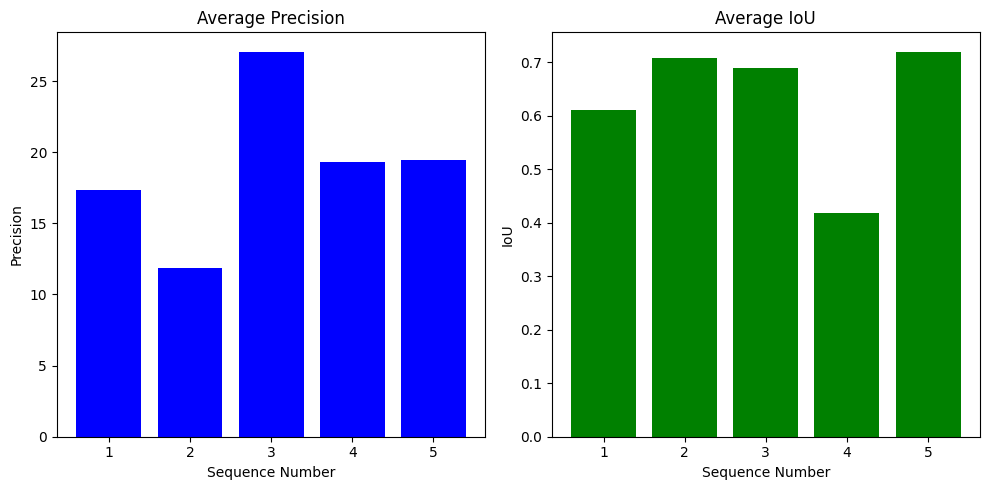

In [ ]:
# Initialize a Kalman Filter for object tracking.
def initialize_kalman(x, y, w, h):
    # Create a Kalman Filter object with 4 dynamic states (x, y position and velocity) and 2 measurement states (x, y position).
    kf = cv2.KalmanFilter(4, 2)
    # Measurement matrix maps the state vector to the measurement vector.
    kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    # Transition matrix defines the relationship between successive states.
    kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    # Process noise covariance matrix (smaller values mean less noise).
    kf.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03
    # Measurement noise covariance matrix (smaller values mean more trust in the measurements).
    kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.1
    # Initial state estimate (center of the bounding box and initial velocity as 0).
    kf.statePre = np.array([x + w / 2, y + h / 2, 0, 0], dtype=np.float32)
    # Initial estimate of error covariance.
    kf.errorCovPre = np.eye(4, dtype=np.float32)
    return kf

# Read bounding box coordinates from a file.
def read_bounding_boxes(file_path):
    # Open the file and convert each line into a tuple of integers (x, y, width, height).
    with open(file_path, 'r') as file:
        return [tuple(map(int, line.strip().split(','))) for line in file]

# Calculate the Intersection over Union (IoU) between two bounding boxes.
def calculate_iou(box1, box2):
    # Determine the coordinates of the intersection rectangle.
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[0] + box1[2], box2[0] + box2[2])
    y_bottom = min(box1[1] + box1[3], box2[1] + box2[3])

    # If there is no overlap, return 0.
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate areas of intersection and union.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = box1[2] * box1[3]
    bb2_area = box2[2] * box2[3]

    # Compute IoU.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

# Calculate precision as the Euclidean distance between the centers of two bounding boxes.
def calculate_precision(gt_box, prediction):
    # Calculate center points of ground truth and prediction.
    gt_center = np.array([gt_box[0] + gt_box[2] / 2, gt_box[1] + gt_box[3] / 2])
    pred_center = np.array([prediction[0], prediction[1]])
    # Compute and return the distance.
    return np.linalg.norm(gt_center - pred_center)

# Main execution block.
base_dir = 'data/Task 1'
sequence_folders = [f'seq_{i}' for i in range(1, 6)]

# Lists to accumulate overall precision and IoU scores.
overall_precision = []
overall_iou = []

# Iterate through each sequence folder to process tracking data.
for sequence_folder in sequence_folders:
    # Paths to the initial state and ground truth data.
    initial_state_path = os.path.join(base_dir, sequence_folder, 'firsttrack.txt')
    ground_truth_path = os.path.join(base_dir, sequence_folder, 'groundtruth.txt')
    # Read ground truth bounding boxes.
    ground_truth_boxes = read_bounding_boxes(ground_truth_path)
    
    # Initialize the Kalman filter with the first bounding box.
    x, y, w, h = read_bounding_boxes(initial_state_path)[0]
    kf = initialize_kalman(x, y, w, h)
    
    # Lists to accumulate precision and IoU for the current sequence.
    precision_accumulator = []
    iou_accumulator = []

    # Iterate through ground truth boxes to predict and correct positions.
    for gt_box in ground_truth_boxes:
        prediction = kf.predict()
        kf.correct(np.array([gt_box[0] + gt_box[2] / 2, gt_box[1] + gt_box[3] / 2], np.float32))
        
        # Create a predicted box based on the Kalman filter's state.
        pred_box = [int(prediction[0] - w / 2), int(prediction[1] - h / 2), w, h]
        # Calculate and accumulate IoU and precision.
        iou = calculate_iou(gt_box, pred_box)
        precision = calculate_precision(gt_box, prediction[:2])
        
        iou_accumulator.append(iou)
        precision_accumulator.append(precision)
    
    # Compute and store average IoU and precision for the current sequence.
    overall_iou.append(np.mean(iou_accumulator))
    overall_precision.append(np.mean(precision_accumulator))

# Print overall IoU and precision across all sequences.
print(f"Overall IoU: {np.mean(overall_iou):.2f}, Overall Precision: {np.mean(overall_precision):.2f}")

# Plotting the results for visualization.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, 6), overall_precision, color='blue')
plt.title("Average Precision")
plt.xlabel("Sequence Number")
plt.ylabel("Precision")

plt.subplot(1, 2, 2)
plt.bar(range(1, 6), overall_iou, color='green')
plt.title("Average IoU")
plt.xlabel("Sequence Number")
plt.ylabel("IoU")
plt.tight_layout()
plt.show()


In [ ]:
base_dir = 'data/Task 1'
sequence_folders = [f'seq_{i}' for i in range(1, 6)]

# Specify the filename for saving results
kalman_results_filename = os.path.join(base_dir, 'kalman_tracking_evaluation_results.csv')

# Write headers to the CSV file, if it's a new file
with open(kalman_results_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Sequence', 'Average Precision', 'Average IoU'])

overall_precision = []
overall_iou = []

for sequence_folder in sequence_folders:
    initial_state_path = os.path.join(base_dir, sequence_folder, 'firsttrack.txt')
    ground_truth_path = os.path.join(base_dir, sequence_folder, 'groundtruth.txt')
    ground_truth_boxes = read_bounding_boxes(ground_truth_path)
    
    x, y, w, h = read_bounding_boxes(initial_state_path)[0]
    kf = initialize_kalman(x, y, w, h)
    
    precision_accumulator = []
    iou_accumulator = []

    for gt_box in ground_truth_boxes:
        prediction = kf.predict()
        kf.correct(np.array([gt_box[0] + gt_box[2] / 2, gt_box[1] + gt_box[3] / 2], np.float32))
        
        pred_box = [int(prediction[0] - w / 2), int(prediction[1] - h / 2), w, h]
        iou = calculate_iou(gt_box, pred_box)
        precision = calculate_precision(gt_box, prediction[:2])
        
        iou_accumulator.append(iou)
        precision_accumulator.append(precision)
    
    avg_iou = np.mean(iou_accumulator)
    avg_precision = np.mean(precision_accumulator)
    overall_iou.append(avg_iou)
    overall_precision.append(avg_precision)

    # Save the sequence results to the CSV file
    with open(kalman_results_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([sequence_folder, avg_precision, avg_iou])

# No plotting in this code snippet; focus is on saving the results
print(f"Overall IoU: {np.mean(overall_iou):.2f}, Overall Precision: {np.mean(overall_precision):.2f}")


Overall IoU: 0.63, Overall Precision: 19.02


#### Saving the results in CSV

C:\Users\ansem\AppData\Local\Temp\ipykernel_21852\2635897690.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(methods, rotation=45, ha='right')
C:\Users\ansem\AppData\Local\Temp\ipykernel_21852\2635897690.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(methods, rotation=45, ha='right')


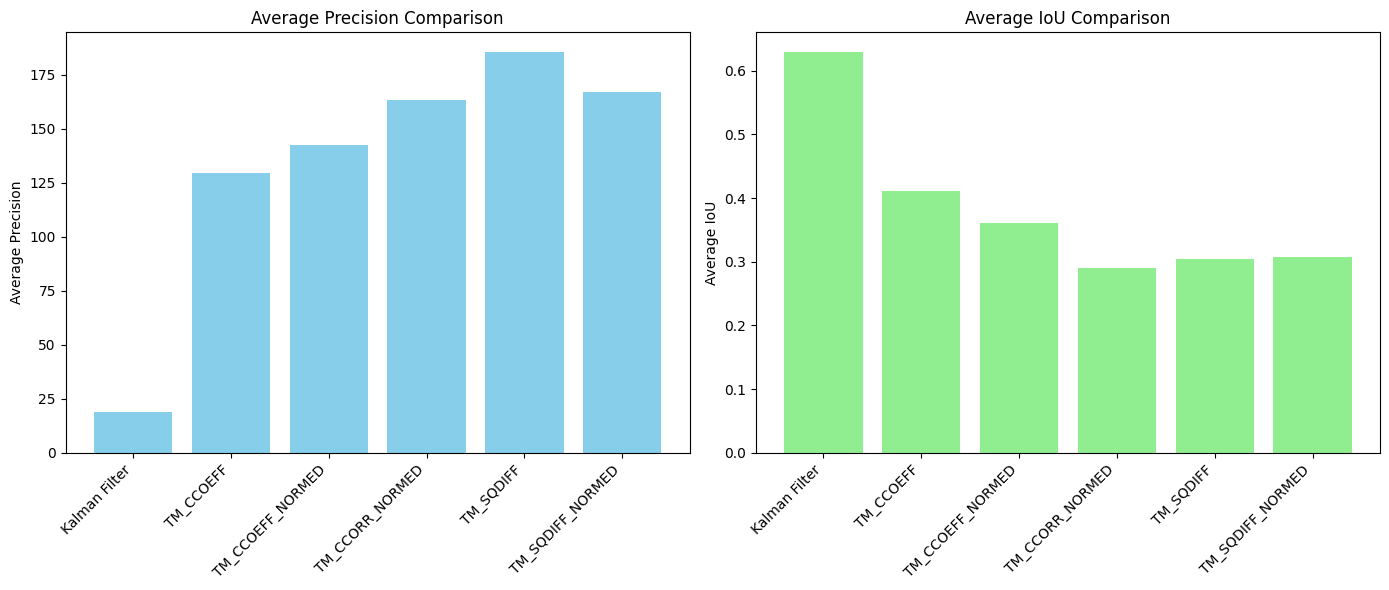

In [ ]:
# Load the CSV data into DataFrames
template_matching_df = pd.read_csv('data/Task 1/tracking_evaluation_results.csv')
kalman_df = pd.read_csv('data/Task 1/kalman_tracking_evaluation_results.csv')

# Aggregate the average precision and IoU for Template Matching across all sequences
template_precision_avg = template_matching_df.groupby('Method')['Average Precision'].mean()
template_iou_avg = template_matching_df.groupby('Method')['Average IoU'].mean()

# For Kalman Filter, directly use the average since there's only one method
kalman_precision_avg = kalman_df['Average Precision'].mean()
kalman_iou_avg = kalman_df['Average IoU'].mean()

# Data for plotting
methods = ['Kalman Filter'] + template_precision_avg.index.tolist()
precision_averages = [kalman_precision_avg] + template_precision_avg.tolist()
iou_averages = [kalman_iou_avg] + template_iou_avg.tolist()

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Precision comparison
axs[0].bar(methods, precision_averages, color='skyblue')
axs[0].set_title('Average Precision Comparison')
axs[0].set_ylabel('Average Precision')
axs[0].set_xticklabels(methods, rotation=45, ha='right')

# IoU comparison
axs[1].bar(methods, iou_averages, color='lightgreen')
axs[1].set_title('Average IoU Comparison')
axs[1].set_ylabel('Average IoU')
axs[1].set_xticklabels(methods, rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Propose Improvements to the work if possible:

### Histogram and Kalman Filter Object Tracking Algorithms 

In [ ]:
# import os
# import shutil

# # Base directory
# base_dir = "data/Task 1"

# # Loop through each sequence
# for seq_num in range(1, 6):
#     seq_path = os.path.join(base_dir, f"seq_{seq_num}")

#     # 1) Delete folders starting with "match"
#     for item in os.listdir(seq_path):
#         item_path = os.path.join(seq_path, item)
#         if os.path.isdir(item_path) and item.startswith("match"):
#             shutil.rmtree(item_path)
#             print(f"Deleted folder: {item_path}")

#     # 2) In "img", delete jpg files starting with "match"
#     img_path = os.path.join(seq_path, "img")
#     for item in os.listdir(img_path):
#         if item.startswith("match") and item.endswith(".jpg"):
#             os.remove(os.path.join(img_path, item))
#             print(f"Deleted file: {os.path.join(img_path, item)}")

#     # 3) Delete all txt files except "firsttrack.txt" and "groundtruth.txt"
#     for item in os.listdir(seq_path):
#         if item.endswith(".txt") and item not in ["firsttrack.txt", "groundtruth.txt"]:
#             os.remove(os.path.join(seq_path, item))
#             print(f"Deleted file: {os.path.join(seq_path, item)}")

#     # 4) Delete all mp4 files
#     for item in os.listdir(seq_path):
#         if item.endswith(".mp4"):
#             os.remove(os.path.join(seq_path, item))
#             print(f"Deleted file: {os.path.join(seq_path, item)}")


Deleted folder: data/Task 1\seq_1\match_TM_CCOEFF
Deleted folder: data/Task 1\seq_1\match_TM_CCOEFF_NORMED
Deleted folder: data/Task 1\seq_1\match_TM_CCORR_NORMED
Deleted folder: data/Task 1\seq_1\match_TM_SQDIFF
Deleted folder: data/Task 1\seq_1\match_TM_SQDIFF_NORMED
Deleted folder: data/Task 1\seq_2\match_TM_CCOEFF
Deleted folder: data/Task 1\seq_2\match_TM_CCOEFF_NORMED
Deleted folder: data/Task 1\seq_2\match_TM_CCORR_NORMED
Deleted folder: data/Task 1\seq_2\match_TM_SQDIFF
Deleted folder: data/Task 1\seq_2\match_TM_SQDIFF_NORMED
Deleted folder: data/Task 1\seq_3\match_TM_CCOEFF
Deleted folder: data/Task 1\seq_3\match_TM_CCOEFF_NORMED
Deleted folder: data/Task 1\seq_3\match_TM_CCORR_NORMED
Deleted folder: data/Task 1\seq_3\match_TM_SQDIFF
Deleted folder: data/Task 1\seq_3\match_TM_SQDIFF_NORMED
Deleted folder: data/Task 1\seq_4\match_TM_CCOEFF
Deleted folder: data/Task 1\seq_4\match_TM_CCOEFF_NORMED
Deleted folder: data/Task 1\seq_4\match_TM_CCORR_NORMED
Deleted folder: data/Task 1